In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import spacy
from collections import Counter
from textblob import TextBlob
from tqdm.notebook import tqdm

### Import initial dataset from kaggle

In [2]:
reviews = pd.read_csv("../data/raw/all_reviews.csv", low_memory=False)
pd.set_option('display.max_columns', None)


### Initial cleaning

In [3]:
# Function to clean numerical rating columns
def clean_rating_columns(df, columns):
    """
    Clean numerical rating columns by converting them to float and removing invalid entries.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=[col])
        df[col] = df[col].astype(float)
    return df

# Function to handle missing values
def handle_missing_values(df, columns_to_fill, fill_value=0.0):
    """
    Fill missing values for specified columns with a given value.
    """
    for col in columns_to_fill:
        df[col] = df[col].fillna(fill_value).astype(float)
    return df

# Function to extract year from date
def extract_year(df, date_column, year_column):
    """
    Extract the year from a date column and create a new year column.
    """
    df[year_column] = df[date_column].str.split().str[2].astype(int)
    df.drop(columns = "date", inplace = True)
    return df[df[year_column] > 2014]

# Function to extract firm names from the firm_link
def extract_firm_names(df, firm_link_column, firm_name_column):
    """
    Extract firm names from firm_link and filter firms with frequent mentions.
    """
    def extract_name(firm_link):
        match = re.search(r'(?<=/)([A-Za-z0-9\-]+)(?=-Reviews)', firm_link)
        return match.group(1) if match else None

    df[firm_name_column] = df[firm_link_column].apply(extract_name)
    df.drop(columns = "firm_link", inplace=True)
    firm_counts = df[firm_name_column].value_counts()
    valid_firms = firm_counts[firm_counts >= 100].index
    
    return df[df[firm_name_column].isin(valid_firms)]

# Function to unify employment statuses
def unify_employment_statuses(df, status_column):
    """
    Standardize employment statuses.
    """
    def unify_status(status):
        if "Current" in status:
            if "Contractor" in status:
                return "Current Contractor"
            elif "Freelancer" in status:
                return "Current Freelancer"
            elif "Intern" in status:
                return "Current Intern"
            elif "Self-employed" in status:
                return "Current Self-employed"
            else:
                return "Current Employee"
        elif "Former" in status:
            if "Contractor" in status:
                return "Former Contractor"
            elif "Freelancer" in status:
                return "Former Freelancer"
            elif "Intern" in status:
                return "Former Intern"
            elif "PhD" in status:
                return "Former PhD"
            elif "Self-employed" in status:
                return "Former Self-employed"
            else:
                return "Former Employee"
        else:
            return "Other"

    df[status_column] = df[status_column].apply(unify_status)
    return df

# Main cleaning function
def clean_dataset(file_path, rating_columns, missing_columns, firm_link_column, status_column, date_column, year_column, job_column):
    """
    Clean the dataset by applying all cleaning functions step by step.
    """
    # Read the data
    df = pd.read_csv(file_path, low_memory=False)
    
    # Clean rating columns
    df = clean_rating_columns(df, rating_columns)
    
    # Drop unnecessary columns
    df.drop(columns=["title", "advice", "index", "Business Outlook"], inplace=True)
    
    # Drop rows with significant missing values
    df.dropna(subset=['pros', 'cons', 'Culture & Values'], inplace=True)

    #Unify names of the columns and reset index
    df['pros'] = df['pros'].str.lower().str.replace(r'\n', ' ', regex=True)
    df['cons'] = df['cons'].str.lower().str.replace(r'\n', ' ', regex=True)
    
    
    # Extract year and filter rows
    df = extract_year(df, date_column, year_column)
    
    # Handle missing values in specific columns
    df = handle_missing_values(df, missing_columns, fill_value=0.0)
    
    # Extract and filter firm names
    df = extract_firm_names(df, firm_link_column, 'firm_name')

    # Unify employment statuses
    df = unify_employment_statuses(df, status_column)
    
    return df

# Usage
file_path = "../data/raw/all_reviews.csv"
rating_columns = ['Work/Life Balance', 'Compensation and Benefits', 'Senior Management', 'Career Opportunities']
missing_columns = ['Diversity & Inclusion']
firm_link_column = 'firm_link'
status_column = 'status'
date_column = 'date'
year_column = 'year'
job_column = 'job'

cleaned_reviews = clean_dataset(
    file_path=file_path,
    rating_columns=rating_columns,
    missing_columns=missing_columns,
    firm_link_column=firm_link_column,
    status_column=status_column,
    date_column=date_column,
    year_column=year_column,
    job_column=job_column
)


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/4252623836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/4252623836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


### Job titles cleaning

In [4]:
def clean_job_titles(df, job_column):
    """
    Clean and standardize job titles in a DataFrame.

    """
    # Replace empty strings or NaN values with "Anonymous Employee"
    df[job_column].replace(' ', 'Anonymous Employee', inplace=True)
    df[job_column].fillna('Anonymous Employee', inplace=True)
    
    # Strip leading/trailing spaces
    df[job_column] = df[job_column].str.strip()
    
    # Count occurrences of each job title
    job_counts = df[job_column].value_counts()
    
    # Filter out jobs mentioned less than 100 times
    valid_jobs = job_counts[job_counts >= 100].index
    df = df[df[job_column].isin(valid_jobs)]
    
    # Replace specific job titles
    job_replacements = {
        'Salees Associate': 'Sales Associate', 'Sales Executive': 'Sales Associate',
        'IT Strategy Consultant': 'IT Consultant',
        'Sales Associate/Cashier': 'Cashier', 'Front End Cashier': 'Cashier',
        'Senior Software Engineer': 'Software Engineer', 
        'Senior Systems Engineer': 'Software Engineer', 
        'Senior Software Developer': 'Software Engineer', 
        'Associate Software Engineer': 'Software Engineer',
        'Sales': 'Sales Associate', 
        'Salees Associate ': 'Sales Associate', 
        'Retail Sales Associate': 'Sales Associate',
        'Sales Assistant': 'Sales Associate', 
        'Sales Representative': 'Sales Associate', 'Inside Sales Representative': 'Sales Associate',
        'Systems Engineer': 'Software Engineer', 'Senior Engineer':'Software Engineer',
        'Senior Associate': 'Associate', 
        'Senior Analyst ': 'Analyst',
        'Business Analyst': 'Analyst', 'Senior Business Analyst ': 'Analyst','Senior Business Analyst': 'Analyst', 'Financial Analyst': 'Analyst',
        'IT Analyst': 'Analyst', 'Senior Analyst': 'Analyst', 'Programmer Analyst': 'Analyst',
        'Server': 'Waiter/Waitress', 'Waiter': 'Waiter/Waitress', 'Waitress': 'Waiter/Waitress',
        'Warehouse Worker': 'Warehouse Associate',
        'Human Resources': 'HR', 
        'Recruiter': 'HR',
        'Customer Service Representative': 'Customer Service', 
        'Customer Service Representative (CSR)': 'Customer Service', 'Customer Service Specialist': 'Customer Service',
        'Customer Assistant': 'Customer Service', 
        'Customer Service Associate': 'Customer Service',
        'Executive Assistant': 'Administrative Assistant', 
        'Associate Director': 'Director',
        'Shift Supervisor': 'Supervisor',
        'Graduate Research Assistant': 'Researcher','Research Assistant': 'Researcher',
    }
    df[job_column] = df[job_column].replace(job_replacements)
    
    # Apply broader job title standardizations
    def standardize_jobs(job):
        if 'Teacher' in job:
            return 'Teacher'
        elif 'Manager' in job:
            return 'Manager'
        elif 'Consultant' in job:
            return 'Consultant'
        elif 'Teller' in job:  
            return 'Bank Teller'
        elif 'Intern' in job:
            return 'Intern'
        elif 'Pharmacy' in job:
            return 'Pharmacy'
        elif 'Team Member' in job or 'Crew Member' in job:
            return 'Team Member'
        return job
    
    df[job_column] = df[job_column].apply(standardize_jobs)
    
    return df

cleaned_reviews = clean_job_titles(cleaned_reviews, 'job') #apply the job cleaning function

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/2627540091.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].replace(job_replacements)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/2627540091.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[job_column] = df[job_column].apply(standardize_jobs)


### Creating industries

In [6]:
# dictionary mapping companies to industries
industry_mapping = {
    'Technology': [
        'CGI', 'Amazon-Flex', 'Publicis-Sapient', 'Pegasystems', 'Tech-Data', 'Unity', 
        'Stefanini', 'Tata-Group', 'Tata-AIA-Life', 'Hi-Rez-Studios', 'Aujas', 
        'S-and-C-Electric-Company', 'LGC', 'TecOrb-Technologies', 'Tower-Semiconductor',
        'CA-Technologies', 'Sysco', 'ALSTOM', 'The-UPS-Store', 'COLSA', 'Hindustan-Times', 
        'Vista-College', 'DreamWorks-Animation', 'Hi-Rez-Studios', 'GlobalData', 'RH', 
        'HUB-International', 'Apex-Tool-Group', 'Conair', 'Emco-Corporation', 'CARQUEST', 
        'Orora', 'Hi-Rez-Studios', 'Electronic-Transaction-Consultants', 'Tower-Semiconductor',
        '3D-Systems', 'Toshiba-America-Business-Solutions', 'Jet', 'Rexel-Group', 'Portland-Communications',
        'Quinnox', 'Quikr-India', 'Tradeindia-com-Infocom-Network','Seiko-Epson', 'SKP-Group', 'REVE-Systems', 'Promact-InfoTech-Pvt'
    ],
    'Finance': [
        'Goldman-Sachs', 'Canada-Life', 'UBS', 'United-Bank-for-Africa', 'Rabobank', 
        'AXA-UK', 'Mercury-General', 'RLI', 'Ecobank', 'Intrum', 'Cadence-Financial', 'ICBC'
    ],
    'Retail': [
        'Chipotle', 'Dunkin', 'H-E-B', 'Ross-Stores', 'GameStop', 'Swarovski', 
        'Calvin-Klein', 'Gymboree', 'Men-s-Wearhouse', 'Famous-Dave-s', 'Savers-Health-and-Beauty', 
        'CARQUEST', 'Orora', 'CALVIN-KLEIN','SeaWorld-Parks-and-Entertainment', 'Lettuce-Entertain-You', 'Wayne-Sanderson-Farms', 'Marc-Glassman'
    ],
    'Healthcare': [
        'Beaumont-Health', 'Nuffield-Health', 'Texas-Health-and-Human-Services-Commission', 
        'Special-Olympics', 'Legacy-Healthcare-Services', 'Indian-Health-Service', 'Extendicare', 
        'Summa-Health-System', 'WW-WeightWatchers', 'WellSky', 'Atrium'
    ],
    'Energy': [
        'Valeo', 'Enersys', 'EnerSys','Hydro-One', 'Vallourec', 'Petrofac'
    ],
    'Media_and_Entertainment': [
        'Norwegian-Cruise-Line-Holdings-Ltd', 'Newsquest', 'Schibsted','DreamWorks-Animation', 'National-Geographic-Society'
    ],
    'Food_and_Beverage': [
        'Tyson-Foods', 'HP-Hood', 'Famous-Dave-s', 'Pernod-Ricard'
    ],
    'Aerospace_and_Defense': [
        'COLSA', 'Stefanini', 'Hi-Rez-Studios'
    ],
    'Consumer_Goods': [
        'Coty', 'GlobalData', 'Movado-Group','Milliken', 'Do-it-Best', 'BBDO', 'Savers-Health-and-Beauty', 'Purity-Cosmetics'
    ],
    'Public_Sector': [
        'New-York-County-District-Attorney', 'Army-Family-and-MWR-Programs', 'Commonwealth-of-Virginia',
        'Palm-Beach-County-School-District', 'University-of-Nevada-Las-Vegas', 'Binding-Site'
    ],
    'Transportation_and_Logistics': [
        'Alaska-Airlines', 'DHL', 'Trinity-Industries','Crowley','Group-1-Automotive', 'Meritage-Homes', 'Jet', 'Rexel-Group',  'Avianca', 'Arriva-Group'
    ],
    'Business_Services': [
        'TriNet', 'NIBCO', 'The-Select-Group','Cpl-Resources', 'Afni', 'EOS-Group', 'Barton-Malow', 'ProTransport-1', 'Portland-Communications', 'Vivo-Global'
    ],
    'Automotive': [
        'Hendrick-Automotive-Group', 'Brose', 'Wayne-Sanderson-Farms'
    ],
    'Education': [
        'Carleton-University', 'Brown-University', 'William-and-Mary', 'Valencia-College', 'Toshiba-America-Business-Solutions'
    ],
    'Telecommunication': ['M1', 'AFL']

}



# create a new column by mapping the firm names to their respective industry
def map_industry(firm_name):
    for industry, companies in industry_mapping.items():
        if firm_name in companies:
            return industry
    return 'Other'  # default category for companies not in the mapping


sampled_reviews = cleaned_reviews.head(100000)
# apply the function to the sampled_reviews DataFrame
sampled_reviews['industry'] = sampled_reviews['firm_name'].apply(map_industry)

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/1163099893.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews['industry'] = sampled_reviews['firm_name'].apply(map_industry)


### Get emotional status

In [7]:
# Function to flag stress, burnout, and anxiety
def emotional_status(text):
    if not isinstance(text, str):  # check if text is not None or NaN
        return False, False, False, False, False, False  # return False for all flags if the text is invalid

    text = text.lower()

    # Keywords for flags
    stress_keywords = ['stress', 'overwhelmed', 'nervous', 'pressure', 'stressful', 'deadlines', 'high demand', 'time pressure',
                       'workload', 'tension', 'deadlines pressure', 'tight schedules','high workload']
    toxic_keywords = ['toxic','negative', 'micromanagement', 'lack of support', 'hostile', 'bullying', 
                      'favoritism', 'harassment', 'isolation', 'unfair', 'discrimination']
    burnout_keywords = ['burnout', 'overtasked', 'overworked', 'burned out', 'burning out', 
                        'drained', 'mental fatigue', 'overcommitment', 'work-life imbalance','exhaustion', 'fatigue']
    anxiety_keywords = ['anxious', 'anxiety', 'panic', 'workload stress', 'job insecurity', 
                        'constant worry', 'fear', 'insecurity']
    depression_keywords= ['depressed','sad','no motivation', 'sleepless', 'unmotivated', 'headaches',
                          'hopelessness', 'lethargy', 'apathy', 'no energy', 'self-doubt', 'dissatisfaction', 'feeling worthless']
    supportive_keywords = ['supportive', 'understanding', 'encouraging', 'teamwork', 'mentorship', 'recognition',
                           'respect', 'empowerment', 'inclusion', 'constructive feedback']    

    # removing unwanted phrases
    unwanted_phrases = ['not too stressful', 'no negatives', 'no cons', 'no complaints', 'not too stressfull']
    if any(phrase in text for phrase in unwanted_phrases):
        if any(keyword in text for keyword in supportive_keywords):
            # keep the text because it includes supportive aspects
            return False, False, False, False, True, False  # Supportive flag is True
        else:
            # discard the text as it is negating sentiment
            return False, False, False, False, False, False



    # check for each set of keywords
    stress_flag = any(keyword in text for keyword in stress_keywords)
    burnout_flag = any(keyword in text for keyword in burnout_keywords)
    anxiety_flag = any(keyword in text for keyword in anxiety_keywords)
    toxic_flag = any(keyword in text for keyword in toxic_keywords)
    supportive_env_flag = any(keyword in text for keyword in supportive_keywords)
    depression_flag = any(keyword in text for keyword in depression_keywords)
    
    return stress_flag, burnout_flag, anxiety_flag, toxic_flag, supportive_env_flag, depression_flag



In [8]:
# apply the emotional_status function to "pros" and "cons"
sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] = pd.DataFrame(
    sampled_reviews['pros'].apply(emotional_status).tolist(), index=sampled_reviews.index)

sampled_reviews[['stress_flag_cons', 'burnout_flag_cons', 'anxiety_flag_cons', 'toxic_flag_cons', 'supportive_env_flag_cons', 'depression_flag_cons']] = pd.DataFrame(
    sampled_reviews['cons'].apply(emotional_status).tolist(), index=sampled_reviews.index)

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/1265215062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] = pd.DataFrame(
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/1265215062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']] 

In [9]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the sentiment analysis function to 'pros' and 'cons'
sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
sampled_reviews[['cons_sentiment', 'cons_subjectivity']] = sampled_reviews['cons'].apply(lambda x: pd.Series(get_sentiment(x)))

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/1633712011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_1463/1633712011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reviews[['pros_sentiment', 'pros_subjectivity']] = sampled_reviews['pros'].apply(lambda x: pd.Series(get_sentiment(x)))
/v

In [10]:
sampled_reviews.columns = sampled_reviews.columns.str.lower().str.replace(" ", "_", regex=True).str.replace("&", "and", regex=True)
sampled_reviews.reset_index(drop=True, inplace=True)
print(sampled_reviews.shape)

(100000, 32)


### Job positions analysis

In [11]:
# Grouping by 'job' and 'year' to calculate mean for each column
job_trends = sampled_reviews.groupby(['job', 'year']).agg({
    'pros_sentiment': 'mean',
    'cons_sentiment': 'mean',
    'rating': 'mean',
    'work/life_balance': 'mean',
    'compensation_and_benefits': 'mean',
    'culture_and_values': 'mean',
    'senior_management': 'mean',
    'diversity_and_inclusion': 'mean'
}).reset_index()

#update job titles
job_replacements = {
        '.NET Developer': 'Software Engineer',
        'Software Developer' : 'Software Engineer',
        'Embedded Software Engineer' : 'Software Engineer',
        'Senior Game Advisor' : 'Game Advisor' }

job_trends['job'] = job_trends['job'].replace(job_replacements)
job_trends = job_trends.round(2)
# Display the resulting aggregated data
display(job_trends)

,job,year,pros_sentiment,cons_sentiment,rating,work/life_balance,compensation_and_benefits,culture_and_values,senior_management,diversity_and_inclusion
0,Software Engineer,2015,0.14,0.00,3.0,4.0,4.0,3.0,2.0,0.0
1,Software Engineer,2017,0.46,-0.35,2.0,3.0,3.0,2.0,2.0,0.0
2,Software Engineer,2018,0.05,-0.21,2.5,3.0,2.0,3.0,1.5,0.0
3,Software Engineer,2020,0.35,-0.08,4.0,5.0,3.0,4.0,4.0,4.0
4,Software Engineer,2021,0.48,-0.06,3.4,3.4,3.0,3.8,3.2,3.4
...,...,...,...,...,...,...,...,...,...,...
9123,Working Student,2023,0.80,0.70,5.0,3.0,5.0,5.0,5.0,5.0
9124,Writer,2016,0.69,-0.03,1.0,3.0,1.0,1.0,1.0,0.0
9125,Writer,2019,0.54,0.42,4.5,4.5,4.5,5.0,4.5,0.0
9126,Writer,2021,0.55,0.02,4.0,4.5,4.0,4.5,4.0,4.0


### Well-Being Indicators

In [12]:
 #list of emotional flags (just the pros flags)
combined_flags = [
    'stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag'
]

combined_flags_df = sampled_reviews.copy()

# combine the pros and cons flags for each emotional state
for flag in combined_flags:
    # Combine the 'pros' and 'cons' flags using the logical OR (|)
    combined_flags_df[flag] = combined_flags_df[flag] | combined_flags_df[flag + '_cons']

# drop the cons flags from the dataframe
for flag in combined_flags:
    combined_flags_df.drop(columns=[flag + '_cons'], inplace=True)

# Check the dataframe to see if the flags have been combined correctly
display(combined_flags_df[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']].head())

,stress_flag,burnout_flag,anxiety_flag,toxic_flag,supportive_env_flag,depression_flag
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False


In [13]:
# group by 'industry' and count the number of True flags for each emotional flag
industry_flag_counts = combined_flags_df.groupby('industry')[['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']].sum()

# create total_flags column by summing across all flag columns for each industry
industry_flag_counts['total_flags'] = industry_flag_counts.sum(axis=1)

# ensure total_flags is of numeric type
industry_flag_counts['total_flags'] = pd.to_numeric(industry_flag_counts['total_flags'], errors='coerce')

# sort by total flags in descending order
industry_flag_counts_sorted = industry_flag_counts.sort_values(by='total_flags', ascending=False)

# Display the sorted result
display(industry_flag_counts_sorted)


,stress_flag,burnout_flag,anxiety_flag,toxic_flag,supportive_env_flag,depression_flag,total_flags
industry,,,,,,,
Retail,2461,540,130,1418,1520,118,6187
Technology,1692,140,172,1178,1927,139,5248
Finance,1214,110,47,462,1030,45,2908
Energy,507,10,7,143,226,18,911
Healthcare,173,52,17,190,238,26,696
Transportation_and_Logistics,134,32,19,157,163,19,524
Business_Services,142,12,26,139,182,12,513
Consumer_Goods,143,16,20,124,136,22,461
Food_and_Beverage,66,11,16,76,83,8,260


In [14]:
# Calculate the percentage contribution of each flag to the total flags
for flag in ['stress_flag', 'burnout_flag', 'anxiety_flag', 'toxic_flag', 'supportive_env_flag', 'depression_flag']:
    industry_flag_counts_sorted[f'{flag}_percentage'] = (
        industry_flag_counts_sorted[flag] / industry_flag_counts_sorted['total_flags'] * 100
    )

# Optional: Round percentages for readability
industry_flag_counts_sorted = industry_flag_counts_sorted.round(2)
industry_flag_counts_sorted


,stress_flag,burnout_flag,anxiety_flag,toxic_flag,supportive_env_flag,depression_flag,total_flags,stress_flag_percentage,burnout_flag_percentage,anxiety_flag_percentage,toxic_flag_percentage,supportive_env_flag_percentage,depression_flag_percentage
industry,,,,,,,,,,,,,
Retail,2461,540,130,1418,1520,118,6187,39.78,8.73,2.10,22.92,24.57,1.91
Technology,1692,140,172,1178,1927,139,5248,32.24,2.67,3.28,22.45,36.72,2.65
Finance,1214,110,47,462,1030,45,2908,41.75,3.78,1.62,15.89,35.42,1.55
Energy,507,10,7,143,226,18,911,55.65,1.10,0.77,15.70,24.81,1.98
Healthcare,173,52,17,190,238,26,696,24.86,7.47,2.44,27.30,34.20,3.74
Transportation_and_Logistics,134,32,19,157,163,19,524,25.57,6.11,3.63,29.96,31.11,3.63
Business_Services,142,12,26,139,182,12,513,27.68,2.34,5.07,27.10,35.48,2.34
Consumer_Goods,143,16,20,124,136,22,461,31.02,3.47,4.34,26.90,29.50,4.77
Food_and_Beverage,66,11,16,76,83,8,260,25.38,4.23,6.15,29.23,31.92,3.08


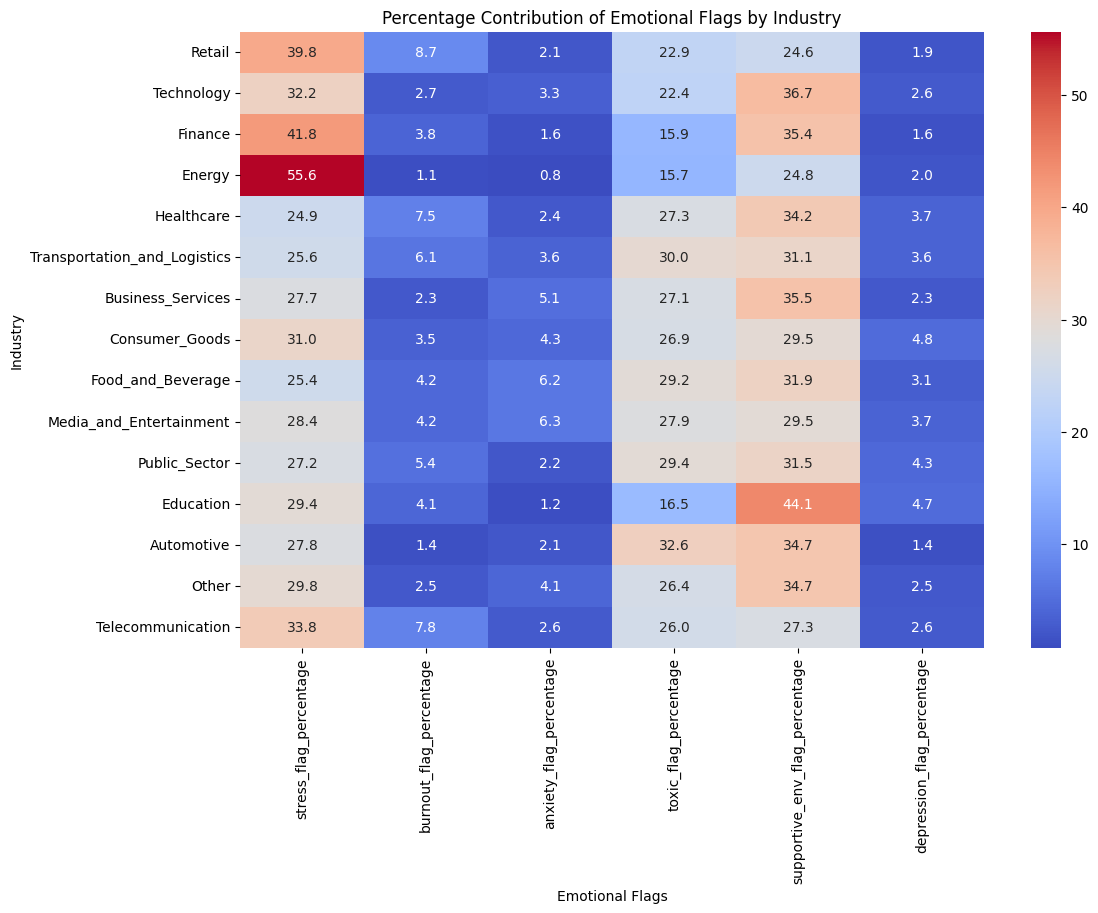

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap for percentages of emotional flags across industries
plt.figure(figsize=(12, 8))
sns.heatmap(
    industry_flag_counts_sorted[[col for col in industry_flag_counts_sorted.columns if '_percentage' in col]],
    annot=True, cmap='coolwarm', fmt='.1f'
)
plt.title('Percentage Contribution of Emotional Flags by Industry')
plt.xlabel('Emotional Flags')
plt.ylabel('Industry')
plt.show()


Save as csv for further analysis

In [ ]:
#industry_flag_counts_sorted.to_csv("../data/clean/percentage_emotions_industry.csv")

In [15]:
# group by 'industry' and count the number of True flags for each emotional flag
cons_industry_sorted = combined_flags_df.groupby('industry')[['stress_flag', 'burnout_flag', 'toxic_flag','depression_flag']].sum()

# create total_flags column by summing across all flag columns for each industry
cons_industry_sorted['total_flags'] = industry_flag_counts.sum(axis=1)

# ensure total_flags is of numeric type
cons_industry_sorted['total_flags'] = pd.to_numeric(industry_flag_counts['total_flags'], errors='coerce')

# sort by total flags in descending order
cons_industry_sorted = cons_industry_sorted.sort_values(by='total_flags', ascending=False)

# Calculate the percentage contribution of each flag to the total flags
for flag in ['stress_flag', 'burnout_flag', 'toxic_flag', 'depression_flag']:
    cons_industry_sorted[f'{flag}_percentage'] = (
        cons_industry_sorted[flag] / cons_industry_sorted['total_flags'] * 100
    )

# Optional: Round percentages for readability
cons_industry_sorted = cons_industry_sorted.round(2)
display(cons_industry_sorted)


,stress_flag,burnout_flag,toxic_flag,depression_flag,total_flags,stress_flag_percentage,burnout_flag_percentage,toxic_flag_percentage,depression_flag_percentage
industry,,,,,,,,,
Retail,2461,540,1418,118,6187,39.78,8.73,22.92,1.91
Technology,1692,140,1178,139,5248,32.24,2.67,22.45,2.65
Finance,1214,110,462,45,2908,41.75,3.78,15.89,1.55
Energy,507,10,143,18,911,55.65,1.10,15.70,1.98
Healthcare,173,52,190,26,696,24.86,7.47,27.30,3.74
Transportation_and_Logistics,134,32,157,19,524,25.57,6.11,29.96,3.63
Business_Services,142,12,139,12,513,27.68,2.34,27.10,2.34
Consumer_Goods,143,16,124,22,461,31.02,3.47,26.90,4.77
Food_and_Beverage,66,11,76,8,260,25.38,4.23,29.23,3.08


In [ ]:
cons_industry_sorted.to_csv("../data/clean/cons_industry_sorted.csv")

In [ ]:
# group by 'industry' and count the number of True flags for each emotional flag
job_emotions_sorted = combined_flags_df.groupby('job')[['stress_flag', 'burnout_flag', 'anxiety_flag','toxic_flag','depression_flag']].sum()

# create total_flags column by summing across all flag columns for each industry
job_emotions_sorted['total_flags'] = job_emotions_sorted.sum(axis=1)

# ensure total_flags is of numeric type
job_emotions_sorted['total_flags'] = pd.to_numeric(job_emotions_sorted['total_flags'], errors='coerce')

# sort by total flags in descending order
job_emotions_sorted = job_emotions_sorted.sort_values(by='total_flags', ascending=False)

# Calculate the percentage contribution of each flag to the total flags
for flag in ['stress_flag', 'burnout_flag', 'toxic_flag', 'anxiety_flag','depression_flag']:
    job_emotions_sorted[f'{flag}_percentage'] = (
        job_emotions_sorted[flag] / job_emotions_sorted['total_flags'] * 100
    )

# Optional: Round percentages for readability
job_emotions_sorted = job_emotions_sorted.round(2)
display(job_emotions_sorted)

,stress_flag,burnout_flag,anxiety_flag,toxic_flag,depression_flag,total_flags,stress_flag_percentage,burnout_flag_percentage,toxic_flag_percentage,anxiety_flag_percentage,depression_flag_percentage
job,,,,,,,,,,,
Anonymous Employee,1597,205,147,1085,118,3152,50.67,6.50,34.42,4.66,3.74
Manager,838,126,74,472,52,1562,53.65,8.07,30.22,4.74,3.33
Team Member,556,140,19,232,16,963,57.74,14.54,24.09,1.97,1.66
Software Engineer,281,6,21,100,20,428,65.65,1.40,23.36,4.91,4.67
Analyst,267,24,12,98,9,410,65.12,5.85,23.90,2.93,2.20
...,...,...,...,...,...,...,...,...,...,...,...
Direct Sales Representative,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
Director IT,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
Phd Student Researcher,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
job_emotions_sorted = job_emotions_sorted.head(20)
job_emotions_sorted

,stress_flag,burnout_flag,anxiety_flag,toxic_flag,depression_flag,total_flags,stress_flag_percentage,burnout_flag_percentage,toxic_flag_percentage,anxiety_flag_percentage,depression_flag_percentage
job,,,,,,,,,,,
Anonymous Employee,1597,205,147,1085,118,3152,50.67,6.50,34.42,4.66,3.74
Manager,838,126,74,472,52,1562,53.65,8.07,30.22,4.74,3.33
Team Member,556,140,19,232,16,963,57.74,14.54,24.09,1.97,1.66
Software Engineer,281,6,21,100,20,428,65.65,1.40,23.36,4.91,4.67
Analyst,267,24,12,98,9,410,65.12,5.85,23.90,2.93,2.20
Sales Associate,200,30,10,150,13,403,49.63,7.44,37.22,2.48,3.23
Cashier,148,25,4,109,4,290,51.03,8.62,37.59,1.38,1.38
Consultant,117,16,20,120,10,283,41.34,5.65,42.40,7.07,3.53
Associate,122,13,3,49,6,193,63.21,6.74,25.39,1.55,3.11


Save for futher analysis

In [ ]:
#job_emotions_sorted.to_csv("../data/clean/job_emotions_sorted.csv")

In [ ]:
# group by 'industry' and count the number of True flags for each emotional flag
yearly_emotional_trends = combined_flags_df.groupby('year')[['stress_flag', 'burnout_flag', 'anxiety_flag', 'supportive_env_flag', 'toxic_flag','depression_flag']].sum()

# create total_flags column by summing across all flag columns for each industry
yearly_emotional_trends['total_flags'] = yearly_emotional_trends.sum(axis=1)

# ensure total_flags is of numeric type
yearly_emotional_trends['total_flags'] = pd.to_numeric(yearly_emotional_trends['total_flags'], errors='coerce')

# sort by total flags in descending order
yearly_emotional_trends = yearly_emotional_trends.sort_values(by='total_flags', ascending=False)
yearly_emotional_trends

,stress_flag,burnout_flag,anxiety_flag,supportive_env_flag,toxic_flag,depression_flag,total_flags
year,,,,,,,
2021,1344,242,58,1075,753,69,3541
2022,1240,227,40,1141,764,59,3471
2017,713,74,62,597,439,59,1944
2018,640,83,60,549,433,53,1818
2020,675,81,46,565,383,44,1794
2016,681,62,77,544,366,54,1784
2019,555,63,55,515,391,51,1630
2015,591,65,67,501,347,34,1605
2023,349,62,17,320,245,14,1007


Save for further analysis

In [ ]:
#yearly_emotional_trends.to_csv("../data/clean/aggregated_flags_by_year.csv")